# Challenger Accident Analysis

## Imports

In [1]:
# import pyspark
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from math import radians, sin, cos, asin, sqrt
from pyspark.sql.functions import lit, expr, col, udf, sum, min, max
import matplotlib.pyplot as plt

/Users/sree/anaconda3/lib/python3.9/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Read and Filter Data

In [2]:
# create spark session
spark = SparkSession.builder.appName("Analysis of Challenger Accident").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# read stations.csv into a spark df
stations_df = spark.read.csv('stations.csv', header=False, inferSchema=True)

# rename the columns
stations_df = stations_df.withColumnRenamed('_c0', 'station_id').withColumnRenamed('_c1', 'wban_id').withColumnRenamed('_c2', 'latitude').withColumnRenamed('_c3', 'longitude')

# drop the wban_id column
stations_df = stations_df.drop('wban_id')

# drop rows with null values
stations_df = stations_df.dropna()

# read temperature data from 1986.csv into a spark df
temp_df = spark.read.csv('1986.csv', header=False, inferSchema=True)

# rename the columns
temp_df = temp_df.withColumnRenamed('_c0', 'station_id').withColumnRenamed('_c1', 'wban_id').withColumnRenamed('_c2', 'month').withColumnRenamed('_c3', 'day').withColumnRenamed('_c4', 'temp')

# drop the wban_id column
temp_df = temp_df.drop('wban_id')

# drop rows with null values
temp_df = temp_df.dropna()


23/04/14 14:39:28 WARN Utils: Your hostname, Sreevatsas-Macbook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.110.19.14 instead (on interface en0)
23/04/14 14:39:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/14 14:39:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# show temp df
temp_df.show()

+----------+-----+---+----+
|station_id|month|day|temp|
+----------+-----+---+----+
|     10010|    1|  1|17.2|
|     10010|    1|  2|12.1|
|     10010|    1|  3|10.4|
|     10010|    1|  4|17.4|
|     10010|    1|  5|26.5|
|     10010|    1|  6|30.1|
|     10010|    1|  7|29.7|
|     10010|    1|  8|29.6|
|     10010|    1|  9|29.6|
|     10010|    1| 10|33.0|
|     10010|    1| 11|32.5|
|     10010|    1| 12|27.4|
|     10010|    1| 13|22.2|
|     10010|    1| 14|11.3|
|     10010|    1| 15| 2.5|
|     10010|    1| 16| 3.0|
|     10010|    1| 17|13.4|
|     10010|    1| 18|29.8|
|     10010|    1| 19|27.5|
|     10010|    1| 20|25.2|
+----------+-----+---+----+
only showing top 20 rows



In [4]:
# show stations df
stations_df.show()

+----------+--------+---------+
|station_id|latitude|longitude|
+----------+--------+---------+
|      7018|     0.0|      0.0|
|      7026|     0.0|      0.0|
|      7070|     0.0|      0.0|
|      8268|   32.95|   65.567|
|      8307|     0.0|      0.0|
|     10010|  70.933|   -8.667|
|     10014|  59.792|    5.341|
|     10015|  61.383|    5.867|
|     10016|   64.85|   11.233|
|     10017|   59.98|     2.25|
|     10020|   80.05|    16.25|
|     10030|    77.0|     15.5|
|     10040|  78.917|   11.933|
|     10050|  78.067|   13.633|
|     10060|   78.25|   22.817|
|     10070|  78.917|   11.933|
|     10071|  78.217|   15.583|
|     10080|  78.246|   15.466|
|     10090|   80.65|     25.0|
|     10100|  69.293|   16.144|
+----------+--------+---------+
only showing top 20 rows



In [5]:
# remove rows with latitude and longitude values of 0
stations_df = stations_df.filter(stations_df.latitude != 0)
stations_df = stations_df.filter(stations_df.longitude != 0)

# show stations df
stations_df.show()

+----------+--------+---------+
|station_id|latitude|longitude|
+----------+--------+---------+
|      8268|   32.95|   65.567|
|     10010|  70.933|   -8.667|
|     10014|  59.792|    5.341|
|     10015|  61.383|    5.867|
|     10016|   64.85|   11.233|
|     10017|   59.98|     2.25|
|     10020|   80.05|    16.25|
|     10030|    77.0|     15.5|
|     10040|  78.917|   11.933|
|     10050|  78.067|   13.633|
|     10060|   78.25|   22.817|
|     10070|  78.917|   11.933|
|     10071|  78.217|   15.583|
|     10080|  78.246|   15.466|
|     10090|   80.65|     25.0|
|     10100|  69.293|   16.144|
|     10110|  80.067|     31.5|
|     10140|  69.233|     17.9|
|     10150|    69.6|   17.833|
|     10160|  78.933|     28.9|
+----------+--------+---------+
only showing top 20 rows



## Calculate Distance

In [6]:
# spark udf to apply haversine formula across spark dataframe
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 6371 for miles
    return c * r

# register haversine function as a spark udf
haversine_udf = udf(haversine)

In [7]:
# cape canaveral coordinates
cape_lat = 28.561944
cape_lon = -80.577778

# add distance column to stations df
stations_df = stations_df.withColumn("distance", haversine_udf(lit(cape_lat), lit(cape_lon), stations_df.latitude, stations_df.longitude))

In [8]:
# filter stations df to only include stations within 100 km of cape canaveral
stations_df = stations_df.filter(stations_df.distance <= 100)

# filter for only the month of january
temp_df = temp_df.filter(temp_df.month == 1)

# join stations df with temp df
stations_temp_df = stations_df.join(temp_df, stations_df.station_id == temp_df.station_id, how='inner').drop(temp_df.station_id)

# show stations_temp_df
stations_temp_df.show()


+----------+--------+---------+-----------------+-----+---+----+
|station_id|latitude|longitude|         distance|month|day|temp|
+----------+--------+---------+-----------------+-----+---+----+
|    722040|    28.1|   -80.65|32.19562863090903|    1|  1|65.0|
|    722040|  28.101|  -80.644|32.07944208590801|    1|  1|65.0|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  2|67.1|
|    722040|  28.101|  -80.644|32.07944208590801|    1|  2|67.1|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  3|64.5|
|    722040|  28.101|  -80.644|32.07944208590801|    1|  3|64.5|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  4|67.6|
|    722040|  28.101|  -80.644|32.07944208590801|    1|  4|67.6|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  5|63.0|
|    722040|  28.101|  -80.644|32.07944208590801|    1|  5|63.0|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  6|51.0|
|    722040|  28.101|  -80.644|32.07944208590801|    1|  6|51.0|
|    722040|    28.1|   -

In [9]:
# drop row if it has same station_id and day
stations_temp_df = stations_temp_df.dropDuplicates(['station_id', 'day'])

# show stations_temp_df
stations_temp_df.show()

+----------+--------+---------+-----------------+-----+---+----+
|station_id|latitude|longitude|         distance|month|day|temp|
+----------+--------+---------+-----------------+-----+---+----+
|    722040|    28.1|   -80.65|32.19562863090903|    1|  1|65.0|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  2|67.1|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  3|64.5|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  4|67.6|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  5|63.0|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  6|51.0|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  7|64.1|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  8|63.5|
|    722040|    28.1|   -80.65|32.19562863090903|    1|  9|65.3|
|    722040|    28.1|   -80.65|32.19562863090903|    1| 10|68.7|
|    722040|    28.1|   -80.65|32.19562863090903|    1| 11|63.1|
|    722040|    28.1|   -80.65|32.19562863090903|    1| 12|56.0|
|    722040|    28.1|   -

## Estimate Temperature

In [10]:
# find inverse distances for each station near cape canaveral
stations_temp_df = stations_temp_df.withColumn("inv_dist", 1 / stations_temp_df.distance)

# find weighted temperatures for each day from each station
stations_temp_df = stations_temp_df.withColumn("weighted_temp", stations_temp_df.inv_dist * stations_temp_df.temp)

# new dataframe with sum of inverse distances and weights for each day of january
stations_temp_df_jan = stations_temp_df.groupBy('day').agg(sum('inv_dist').alias('sum_inv_dist'), sum('weighted_temp').alias('sum_weighted_temp'))

# final weighted temperature readings for each day of january
stations_temp_df_jan = stations_temp_df_jan.withColumn("est_temp", stations_temp_df_jan.sum_weighted_temp / stations_temp_df_jan.sum_inv_dist)

# show stations_temp_df_jan
stations_temp_df_jan.show()


+---+------------------+------------------+------------------+
|day|      sum_inv_dist| sum_weighted_temp|          est_temp|
+---+------------------+------------------+------------------+
| 31|0.3932614029823372|21.936263184893484|  55.7803614047492|
| 28|0.3932614029823372|13.519942378470471|34.379021881986475|
| 26|0.3804368143441904|21.730360587676554| 57.11949992309779|
| 27|0.3932614029823372| 17.98650840307548|45.736775250947574|
| 12|0.3932614029823372|  22.1510896459328|56.326630271742395|
| 22|0.3932614029823372|22.775833047255162|57.915251470224014|
|  1|0.3804368143441904| 23.48138713186139|  61.7221736869482|
| 13|0.3932614029823372|21.237736802880146|54.004122046612366|
|  6|0.3932614029823372| 20.33033065417926| 51.69673530125805|
| 16|0.3932614029823372|22.341354529660535| 56.81044302907084|
|  3|0.3932614029823372|24.798405553802223| 63.05832549480074|
| 20|0.3804368143441904|21.671307514114766| 56.96427553014942|
|  5|0.3804368143441904|22.836044112900332|60.025852524

In [11]:
# use collect() to get the data from the spark dataframe for 28th day of january
stations_temp_df_jan_28 = stations_temp_df_jan.filter(stations_temp_df_jan.day == 28).collect()

# print the estimated temperature for the 28th day of january
print("Estimated temperature for the January 28th at Cape Canaveral: " + str(round(stations_temp_df_jan_28[0].est_temp, 2)) + " degrees Fahrenheit.")

Estimated temperature for the January 28th at Cape Canaveral: 34.38 degrees Fahrenheit.


In [12]:
# sort stations_temp_df_jan by day
stations_temp_df_jan = stations_temp_df_jan.sort('day')

# show stations_temp_df
stations_temp_df_jan.show()

+---+------------------+------------------+------------------+
|day|      sum_inv_dist| sum_weighted_temp|          est_temp|
+---+------------------+------------------+------------------+
|  1|0.3804368143441904| 23.48138713186139|  61.7221736869482|
|  2|0.3932614029823372|25.335728433423153| 64.42465047748678|
|  3|0.3932614029823372|24.798405553802223| 63.05832549480074|
|  4|0.3932614029823372|25.870948138692896|  65.7856274287229|
|  5|0.3804368143441904|22.836044112900332|60.025852524987265|
|  6|0.3932614029823372| 20.33033065417926| 51.69673530125805|
|  7|0.3932614029823372|23.662427201896932|60.169716688316086|
|  8|0.3932614029823372|23.776323268112655|60.459335922118285|
|  9|0.3932614029823372|24.579455849261695|62.501571887962896|
| 10|0.3932614029823372| 25.70919068996335| 65.37430445753164|
| 11|0.3804368143441904| 22.13566184843075| 58.18485754747194|
| 12|0.3932614029823372|  22.1510896459328|56.326630271742395|
| 13|0.3932614029823372|21.237736802880146|54.004122046

In [13]:
# convert day column to list with collect()
day_list = stations_temp_df_jan.select('day').collect()

# convert est_temp column to list with collect()
est_temp_list = stations_temp_df_jan.select('est_temp').collect()

# convert day_list to list of integers
day_list = [int(day.day) for day in day_list]

# convert est_temp_list to list of floats
est_temp_list = [float(temp.est_temp) for temp in est_temp_list]


## Plot Temperature

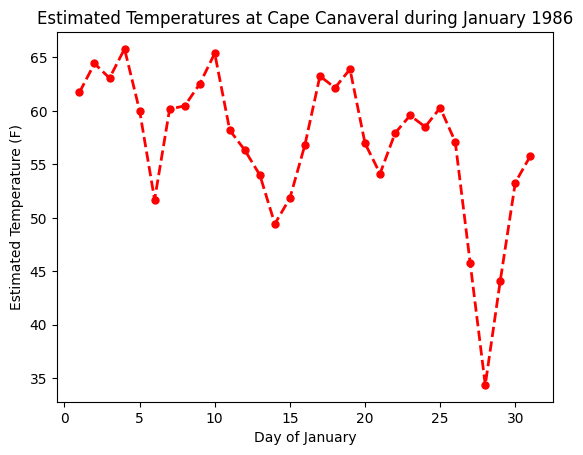

In [14]:
# plot the estimated temperatures for each day of january
plt.plot(day_list, est_temp_list, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.xlabel('Day of January')
plt.ylabel('Estimated Temperature (F)')
plt.title('Estimated Temperatures at Cape Canaveral during January 1986')
plt.show()

## Analysis

On January 28th, the temperature at Cape Canaveral was at its lowest. The effect of the temperature on the launch led to the failed launch and subsequent explosion. The volatility of th temperature at the launch site is a major factor in the failure of the launch. If NASA had waited until the 30th, the temperature would have been much higher and the launch would probably have been successful. The weather at the launch site is a major factor in the success of the launch.